<a href="https://colab.research.google.com/github/jjonhwa/DeepLearning.AI-TensorFlow/blob/main/31_S%2BP_Week_2_Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def plot_series(time, series, format = '-', start = 0, end = None) :
  plt.plot(time[start:end], series[start :end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope = 0) :
  return slope * time

def seasonal_pattern(season_time) :
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  
def seasonality(time, period, amplitude = 1, phase = 0) :
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None) :
  rnd = np.random.RandomState(seed)
  return rnd.random(len(time)) * noise_level

In [9]:
time = np.arange(4 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [10]:
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time :]
x_valid = series[split_time :]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer) :
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

IO = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([IO])

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))
model.fit(dataset, epochs = 100, verbose = 0)

print('Layer weights {}'.format(IO.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.11540423],
       [ 0.17014733],
       [ 0.0695063 ],
       [-0.23899078],
       [ 0.0484778 ],
       [ 0.20959185],
       [-0.10666571],
       [-0.06636145],
       [-0.18567733],
       [ 0.41632003],
       [-0.07333117],
       [-0.27469546],
       [-0.09178168],
       [ 0.19294491],
       [ 0.20653315],
       [-0.2685278 ],
       [ 0.37722155],
       [-0.17315029],
       [ 0.14036924],
       [ 0.77190167]], dtype=float32), array([0.01051462], dtype=float32)]


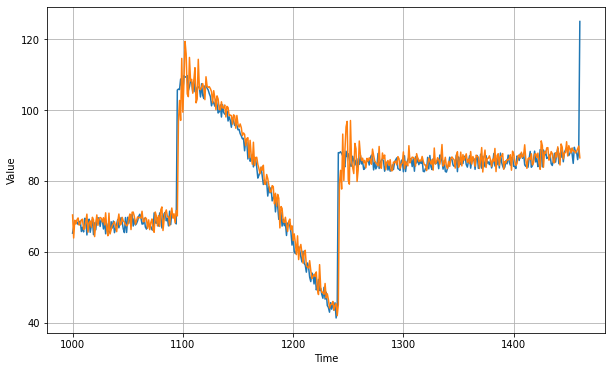

In [17]:
forecast = []

for time in range(len(series) - window_size) :
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.5294352